# COGS 108 - EDA Checkpoint

# Names

- Allison Bhavsar
- Jon Chang
- Mikaela Grenion
- Nathan Nakamura
- Tilak Patel

<a id='research_question'></a>
# Research Question

Is there a relationship between race and reason for wrongful conviction among exonerees in the United States?

# Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_excel ('data/publicspreadsheet.xlsx')
df

,Last Name,First Name,Age,Race,Sex,State,County,Tags,Worst Crime Display,List Add'l Crimes Recode,...,*,FC,MWID,F/MFE,P/FA,OM,ILD,Posting Date,OM Tags,Occurred
0,Abbitt,Joseph,31.0,Black,Male,North Carolina,Forsyth,CV;#IO,Child Sex Abuse,Sexual Assault;#Kidnapping;#Burglary/Unlawful ...,...,NaN,NaN,MWID,NaN,NaN,NaN,NaN,2011-09-01,NaN,1991
1,Abdal,Warith Habib,43.0,Black,Male,New York,Erie,IO,Sexual Assault,Robbery,...,NaN,NaN,MWID,F/MFE,NaN,OM,NaN,2011-08-29,OF;#WH;#NW;#WT,1982
2,Abernathy,Christopher,17.0,White,Male,Illinois,Cook,CIU;#CV;#H;#IO,Murder,Rape;#Robbery,...,NaN,FC,NaN,NaN,P/FA,OM,NaN,2015-02-13,OF;#WH;#NW;#INT,1984
3,Abney,Quentin,32.0,Black,Male,New York,New York,CV,Robbery,NaN,...,NaN,NaN,MWID,NaN,NaN,NaN,NaN,2019-05-13,NaN,2005
4,Acero,Longino,35.0,Hispanic,Male,California,Santa Clara,NC;#P,Sex Offender Registration,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ILD,2011-08-29,NaN,1994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2760,Zawacki,Richard,38.0,White,Male,Indiana,Huntington,CV;#NC,Child Sex Abuse,NaN,...,NaN,NaN,NaN,NaN,P/FA,NaN,NaN,2017-08-08,NaN,2000
2761,Zimmer,Walter,40.0,White,Male,Ohio,Cuyahoga,CDC;#H;#IO,Manslaughter,Attempted Murder;#Robbery;#Assault;#Kidnapping...,...,*,NaN,NaN,F/MFE,P/FA,OM,NaN,2013-10-04,FA;#WH;#NW;#PJ,1997
2762,Zimmerman,Evan,53.0,White,Male,Wisconsin,Dodge,H;#IO,Murder,NaN,...,*,FC,NaN,NaN,NaN,NaN,ILD,2011-08-29,NaN,2000
2763,Zinkiewicz,Tyrone,38.0,White,Male,Ohio,Montgomery,CV;#NC,Other Nonviolent Felony,NaN,...,NaN,NaN,NaN,NaN,P/FA,OM,NaN,2014-10-25,PR;#WH,1988


# Data Cleaning

Describe your data cleaning steps here.

First, we removed columns for variables that did not pertain to our research question and those containing identifying information in order to anonymize the data. We also dropped rows where race was unknown since we cannot make assumptions about race. Additionally, we renamed the exoneration reason columns to be more meaningful.

In [2]:
# Dropped columns irrelevant to our research question and dropped columns with identifying information like names
df2 = df.drop(["Last Name", "First Name", "Sex", "Sentence", "Convicted", "Exonerated", "Occurred", "County", "State", "Posting Date", "Tags", "OM Tags", "*", "List Add'l Crimes Recode"], axis=1)

# Dropped rows where race infornation is unknown (either "Other" or "Don't Know")
df2 = df2[(df2['Race'] != "Don't Know") & (df2['Race'] != 'Other')]

In [3]:
# Renamed acronyms with clearer names
df2 = df2.rename(columns={"FC" : "False Confession", "MWID": "Witness Misidentification", "F/MFE": "False Evidence", "P/FA": "Perjury", "OM": "Official Misconduct", "ILD": "Legal Defense"})

To clean the exoneration reason columns, we changed NaNs to 0s and other values to 1s to indicate that the variable was a reason for the individual's exoneration. This allows us to take the sum of a reason column in order to get the counts of how many exonerees this reason pertains to.

In [4]:
# Made exoneration reason columns booleans (1 if it was a reason, 0 otherwise replacing NaNs)
df2.update(df2[["DNA", "False Confession", "Witness Misidentification","False Evidence","Perjury","Official Misconduct","Legal Defense"]].fillna(0))
df2 = df2.replace({"DNA": 1,"FC" :1,"MWID":1, "F/MFE": 1, "P/FA": 1, "OM": 1, "ILD": 1})

Finally, we standardized the worst crime column, categorizing the large variety of crimes into 7 distinct groups: sex crimes, violent crimes, property crimes, consensual crimes, white collar crimes, harrassment crimes, and nonviolent crimes. This helps us make sense of how type of crime might also correlate to reason for exoneration in addition to race.

In [5]:
def standardize_crime(string):
    if "Sex" in string:
        output = 'sex crimes'
    elif (string == 'Murder' or string == 'Robbery' or string == 'Manslaughter' or string == 'Assault'
        or string == 'Kidnapping' or string == 'Other Violent Felony' or string == 'Attempted Murder'
        or string == 'Child Abuse' or string == 'Attempt, Violent' or string == 'Accessory to Murder'
        or string == 'Traffic Offense' or string == 'Supporting Terrorism' or string == 'Other Violent Misdemeanor'
        or string == 'Dependent Adult Abuse'):
        output = 'violent crimes'
    elif (string == 'Theft' or string == 'Burglary/Unlawful Entry' or string == 'Arson'
         or string == 'Possession of Stolen Property' or string == 'Destruction of Property'):
        output = 'property crimes'
    elif (string == 'Drug Possession or Sale' or string == 'Weapon Possession or Sale' or string == 'Solicitation'
         or string == 'Conspiracy'):
        output = 'consensual crimes'
    elif (string == 'Bribery' or string == 'Fraud' or string == 'Tax Evasion/Fraud' or string == 'Perjury'
         or string == 'Threats' or string == 'Filing a False Report' or string == 'Official Misconduct'
         or string == 'Forgery' or string == 'Obstruction of Justice'):
        output = 'white collar crimes'
    elif (string == 'Stalking' or string == 'Menacing' or string == 'Harrassment'):
        output = 'harrassment crimes'
    elif (string == 'Immigration' or string == 'Other Nonviolent Felony' or string == 'Other Nonviolent Misdemeanor'
         or string == 'Failure to Pay Child Support'):
        output = 'nonviolent crimes'
    else:
        output = ''
        
    return output

df2['Worst Crime Display'] = df2['Worst Crime Display'].apply(standardize_crime)
df2 = df2[df2['Worst Crime Display'] != '']

### The cleaned dataset:

In [6]:
df2

,Age,Race,Worst Crime Display,DNA,False Confession,Witness Misidentification,False Evidence,Perjury,Official Misconduct,Legal Defense
0,31.0,Black,sex crimes,1,0,1,0,0,0,0
1,43.0,Black,sex crimes,1,0,1,1,0,1,0
2,17.0,White,violent crimes,1,1,0,0,1,1,0
3,32.0,Black,violent crimes,0,0,1,0,0,0,0
4,35.0,Hispanic,sex crimes,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2760,38.0,White,sex crimes,0,0,0,0,1,0,0
2761,40.0,White,violent crimes,1,0,0,1,1,1,0
2762,53.0,White,violent crimes,1,1,0,0,0,0,1
2763,38.0,White,nonviolent crimes,0,0,0,0,1,1,0


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

### Distribution of Race
We first visualize race to understand the distribution of Black, White, Hispanic, Asian, and Native American exonerees in the dataset.

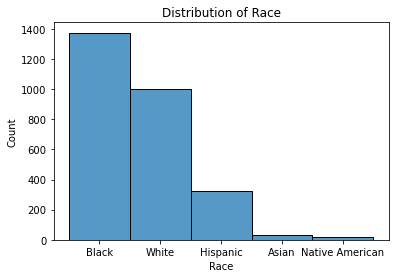

In [7]:
#Plot the distributions of race in  our data set
ax = sns.histplot(df2['Race'], kde=False)
ax.set_title('Distribution of Race')
plt.show()

From this distribution we can see that the majority of the data comes from exonerations involving Black (~1350) or White individuals (1000). Hispanic individuals represent about 300 observations and Asians and Native Americans have < 200 observations. 

### Exoneration Reason Counts
For exoneration reasons __(DNA, False Confession, Witness Misidentification, False Evidence, Perjury, Official Misconduct, Legal Defense)__, we look at the total counts of individuals that were and were not exonerated for each reason. Here 0 indicates that an exoneree was not exonerated for the corresponding reason, while a 1 indicates that they were exonerated for this reason.

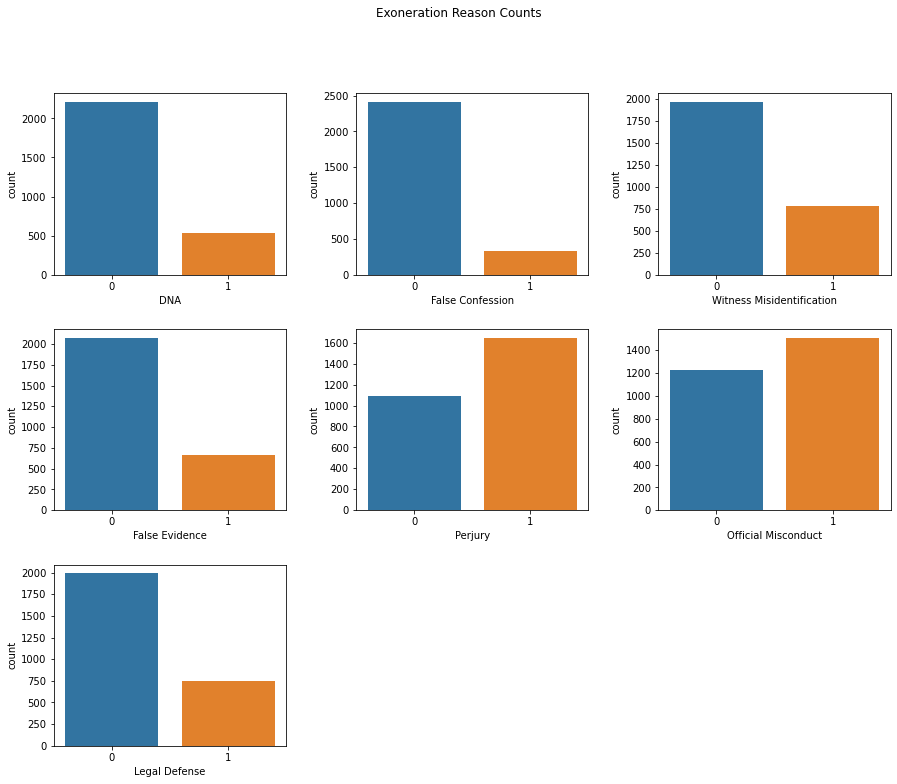

In [8]:
#Plot the distributions of the reasons for each wrongful conviction (DNA, False Confession, Witness Misidentification, False Evidence, Perjury, Offical Misconduct, Legal Defense)
fig, ax = plt.subplots(3,3, figsize=(15,12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
sns.countplot(x='DNA', data=df2, ax=ax[0][0])
sns.countplot(x='False Confession', data=df2, ax=ax[0][1])
sns.countplot(x='Witness Misidentification', data=df2, ax=ax[0][2])
sns.countplot(x='False Evidence', data=df2, ax=ax[1][0])
sns.countplot(x='Perjury', data=df2, ax=ax[1][1])
sns.countplot(x='Official Misconduct', data=df2, ax=ax[1][2])
sns.countplot(x='Legal Defense', data=df2, ax=ax[2][0])
ax[2, 1].axis('off')
ax[2, 2].axis('off')
fig.suptitle('Exoneration Reason Counts');

From plotting each of the reasons for wrongful convictions, we are able to see that fewer cases involve DNA and False Confession.
About 750 cases involve inadequate Legal Defense, Witness Misidentification, and False Evidence.
A majority of the cases cite Official misconduct and perjury as reasons for wrongful conviction.

### Race by exoneration reason
To begin understanding the relationship between race and reason, we visualize the proportion of each race exonerated for a given reason (out of the total number of exonerees of that race since we saw earlier that the distribution of races is not uniform). We will consider this for all 7 reasons for exoneration.

In [9]:
# function to plot proportion of each race exonerated for a given reason
def plot_race_by_reason(reason):
    proportions = (df2.groupby(['Race']))[reason].value_counts(normalize=True).rename('proportion').reset_index()
    proportions = proportions[proportions[reason] == 1]
    proportions
    ax = sns.barplot(x='Race', y='proportion', data=proportions)
    ax.set_title(reason)
    return ax

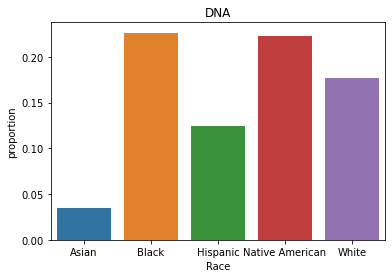

In [10]:
plot_race_by_reason('DNA');

Compared to their proportion in the dataset, about 30% of Black and Native American individuals' cases involve DNA, with a lower proportion of corresponding White, Hispanic, and Asian cases.

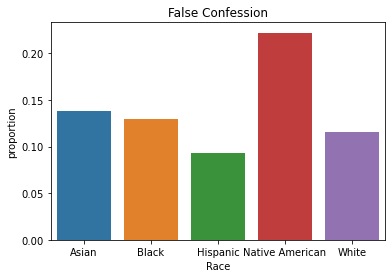

In [11]:
plot_race_by_reason('False Confession');

From this visualization we can see that Native Americans stand out as having a notably higher proportion of cases involving false confession.

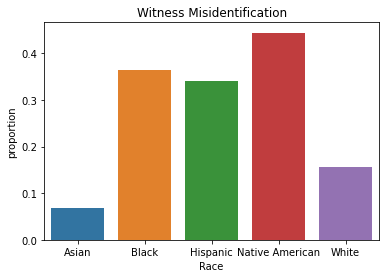

In [12]:
plot_race_by_reason('Witness Misidentification');

For witness misidentification, the largest proportions are Black, Hispanic, and Native American.

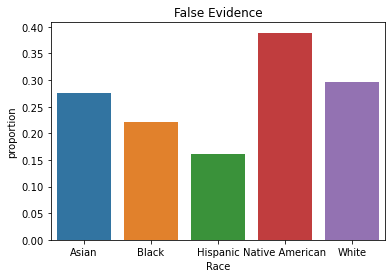

In [13]:
plot_race_by_reason('False Evidence');

Native Americans and Whites have the largest proportion of cases involving false evidence.

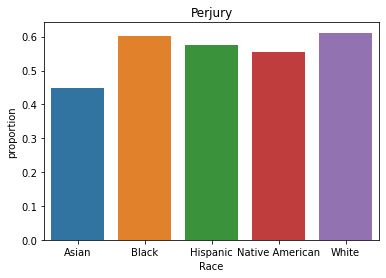

In [14]:
plot_race_by_reason('Perjury');

Compared to the other reasons for exoneration, perjury has much higher proportions across all races. However, the proportion for Asians is noticeably lower compared to that of other races.

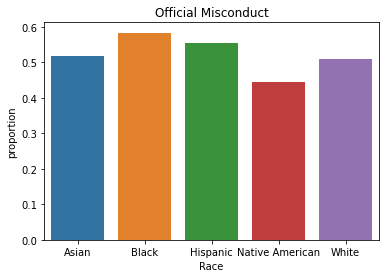

In [15]:
plot_race_by_reason('Official Misconduct');

Official misconduct also has higher proportions across the board.

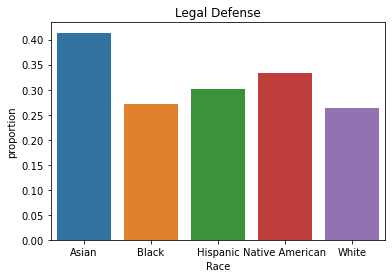

In [16]:
plot_race_by_reason('Legal Defense');

For legal defense, the proportion of Asians is significantly higher than the other races.

### Exoneration Reason by Race
To further our understanding about the relationship between reason for exoneration and race, we look at the exoneration reason breakdown for each race individually. Since we used 0s and 1s to encode the values in the reason columns, we can take the sum of a column to get its count.

In [17]:
# function to plot the distribution of reasons within a specified race
def plot_reasons_by_race(race):
    df_race = df2[df2['Race'] == race]
    ax = sns.barplot(y=['Perjury', 'Legal Defense', 'DNA', 'Witness Misidentification',
                    'False Confession', 'False Evidence', 'Official Misconduct'],
                x=[df_race['Perjury'].sum(), df_race['Legal Defense'].sum(), df_race['DNA'].sum(),
                   df_race['Witness Misidentification'].sum(), df_race['False Confession'].sum(),
                   df_race['False Evidence'].sum(), df_race['Official Misconduct'].sum()])
    ax.set_title('{f_race} exonerees'.format(f_race = race))
    ax.set_xlabel('Count');
    return ax

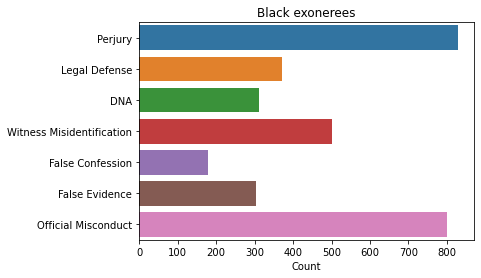

In [18]:
plot_reasons_by_race('Black');

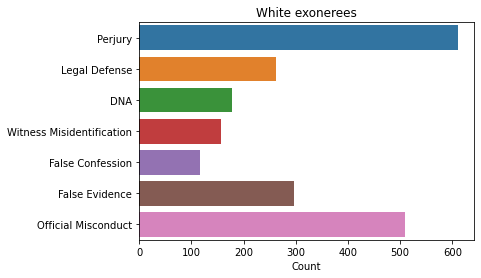

In [19]:
plot_reasons_by_race('White');

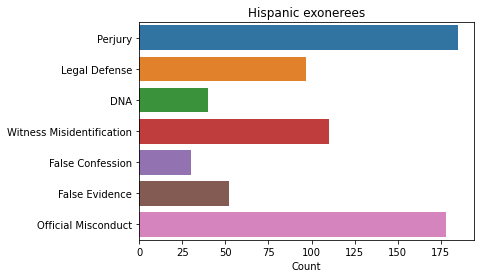

In [20]:
plot_reasons_by_race('Hispanic');

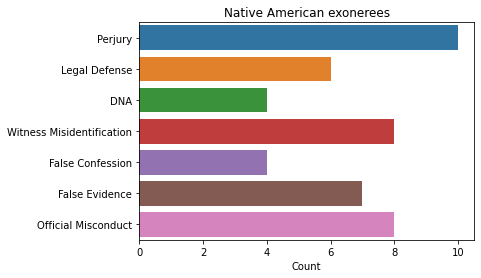

In [21]:
plot_reasons_by_race('Native American');

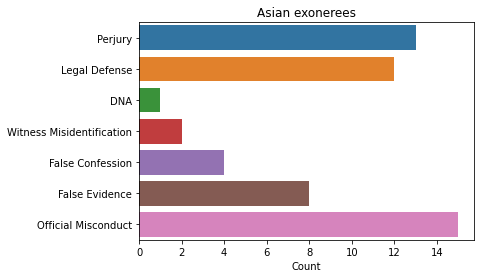

In [22]:
plot_reasons_by_race('Asian');

When looking at the distribution of reason for exoneration by race, perjury and official misconduct are consistently the top two reasons among all races. For 3 of the races (Black, Hispanic, Native American) witness misidentification is the 3rd highest reason for exoneration, while among Asians and Whites it is the 2nd lowest reason for exoneration.